## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression as lr
from sklearn.tree import DecisionTreeRegressor as tree

DATA_PATH = "../input/ashrae-energy-prediction/"

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load Data

In [2]:
train_df = pd.read_csv('train.csv')

# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
test_df=pd.read_csv('test.csv')
building_df = pd.read_csv( 'building_metadata.csv')

train_test=pd.concat([train_df,test_df])

weather_train = pd.read_csv( 'weather_train.csv')
weather_test = pd.read_csv( 'weather_test.csv')

#weather_df = weather_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [3]:
weather_train = weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test = weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_df=pd.concat([weather_train,weather_test])

In [4]:
#weather_filled(weather_df)
weather_df.shape[0]==weather_train.shape[0]+weather_test.shape[0]

True

In [5]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [7]:
df

,building_id,meter,meter_reading,row_id,timestamp
103,105,0,23.3036,NaN,2016-01-01 00:00:00
104,106,0,0.3746,NaN,2016-01-01 00:00:00
105,106,3,0.0000,NaN,2016-01-01 00:00:00
106,107,0,175.1840,NaN,2016-01-01 00:00:00
107,108,0,91.2653,NaN,2016-01-01 00:00:00
...,...,...,...,...,...
41697595,1444,0,NaN,41697595.0,2018-05-09 07:00:00
41697596,1445,0,NaN,41697596.0,2018-05-09 07:00:00
41697597,1446,0,NaN,41697597.0,2018-05-09 07:00:00
41697598,1447,0,NaN,41697598.0,2018-05-09 07:00:00


In [6]:
    #interpolate data
    #weather_df = weather_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)
    
    

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    #weather_df["air_temperature_x"]=round(weather_df["air_temperature_x"].astype(float).round(2),2)
    #weather_df["dew_temperature_x"]=round(weather_df["dew_temperature_x"].astype(float).round(2),2)
    #weather_df["wind_speed_x"]=round(weather_df["wind_speed_x"].astype(float).round(2),1)
    #weather_df["air_temperature_y"]=round(weather_df["air_temperature_y"].astype(float).round(2),2)
    #weather_df["dew_temperature_y"]=round(weather_df["dew_temperature_y"].astype(float).round(2),2)
    #weather_df["wind_speed_y"]=round(weather_df["wind_speed_y"].astype(float).round(2),1)
    
    weather_df["air_temperature"]=round(weather_df["air_temperature"].astype(float).round(2),2)
    weather_df["dew_temperature"]=round(weather_df["dew_temperature"].astype(float).round(2),2)
    weather_df["wind_speed"]=round(weather_df["wind_speed"].astype(float).round(2),1)    
    weather_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,timestamp,wind_direction,wind_speed
0,0,25.00,6.000000,20.00,-1.000000,1019.700000,2016-01-01 00:00:00,0.00000,0.0
1,0,24.40,4.000000,21.10,-1.000000,1020.200000,2016-01-01 01:00:00,70.00000,1.5
2,0,22.80,2.000000,21.10,0.000000,1020.200000,2016-01-01 02:00:00,0.00000,0.0
3,0,21.10,2.000000,20.60,0.000000,1020.100000,2016-01-01 03:00:00,0.00000,0.0
4,0,20.00,2.000000,20.00,-1.000000,1020.000000,2016-01-01 04:00:00,250.00000,2.6
...,...,...,...,...,...,...,...,...,...
420859,15,4.11,2.133965,0.54,0.770661,1014.370455,2018-12-01 07:00:00,234.69697,4.2
420860,15,4.11,2.133965,0.54,0.770661,1014.370455,2018-12-01 08:00:00,234.69697,4.2
420861,15,4.11,2.133965,0.54,0.770661,1014.370455,2018-12-01 09:00:00,234.69697,4.2
420862,15,4.11,2.133965,0.54,0.770661,1014.370455,2018-12-01 10:00:00,234.69697,4.2


## Utility Functions

In [7]:

def weather_filled(weather_df):
    
    
    
    
    #interpolate data
    weather_df = weather_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)
    
    

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    #weather_df["air_temperature_x"]=round(weather_df["air_temperature_x"].astype(float).round(2),2)
    #weather_df["dew_temperature_x"]=round(weather_df["dew_temperature_x"].astype(float).round(2),2)
    #weather_df["wind_speed_x"]=round(weather_df["wind_speed_x"].astype(float).round(2),1)
    #weather_df["air_temperature_y"]=round(weather_df["air_temperature_y"].astype(float).round(2),2)
    #weather_df["dew_temperature_y"]=round(weather_df["dew_temperature_y"].astype(float).round(2),2)
    #weather_df["wind_speed_y"]=round(weather_df["wind_speed_y"].astype(float).round(2),1)
    
    weather_df["air_temperature"]=round(weather_df["air_temperature"].astype(float).round(2),2)
    weather_df["dew_temperature"]=round(weather_df["dew_temperature"].astype(float).round(2),2)
    weather_df["wind_speed"]=round(weather_df["wind_speed"].astype(float).round(2),1)    
    return weather_df



from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    #drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    #df = df.drop(drop, axis=1)
    df = df.drop("timestamp", axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

## Fill Weather Information



In [1]:
#weather_df=weather_filled(weather_df)


## Fill Metadata Information

In [8]:
building_df=pd.read_csv("building_metadata.csv")


building_df=building_df.replace(building_df["primary_use"].unique(),range(len(building_df["primary_use"].unique())))
building_df.head()

building_df_na=building_df.dropna(subset=["year_built","floor_count"])
y=building_df_na.floor_count
X=building_df_na.drop("floor_count",axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)
clf=tree()
clf.fit(X_train,y_train)
prediction=clf.predict(X_test)

building_df_na=building_df.dropna(subset=["year_built"])
building_df_na=building_df_na[(building_df_na["floor_count"].isnull()==True)]

X_to_predict=building_df_na.drop(["floor_count"],axis=1)
clf.fit(X,y)
building_df_na["floor_count"]=clf.predict(X_to_predict)
building_df_na.head()

building_df=pd.concat([ building_df[((building_df["floor_count"].isnull()==True) &  (building_df["year_built"].isnull()==True))]
             ,building_df.dropna(subset=["floor_count","year_built"])
             ,building_df_na,
            building_df[building_df["year_built"].isnull()==True].dropna(subset=['floor_count'])],
            ignore_index=False)



building_df["year_built"]=building_df["year_built"].groupby(building_df["primary_use"]).transform(lambda x: x.fillna(x.median()))
building_df["year_built"]=building_df["year_built"].transform(lambda x: x.fillna(x.median()))
building_df_na=building_df.dropna(subset=["floor_count"])
y=building_df_na.floor_count
X=building_df_na.drop("floor_count",axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)
clf=tree()
clf.fit(X_train,y_train)
prediction=clf.predict(X_test)

building_df_na=building_df[(building_df["floor_count"].isnull()==True)]
X_to_predict=building_df_na.drop(["floor_count"],axis=1)
clf.fit(X,y)
building_df_na["floor_count"]=clf.predict(X_to_predict)
building_df_na.head()

building_df=pd.concat([
             building_df_na,
            building_df.dropna()],
            ignore_index=False)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Memory Reduction

In [9]:

train_test = reduce_mem_usage(train_test,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=False)


Memory usage of dataframe is 2817.54 MB
Memory usage after optimization is: 1234.12 MB
Decreased by 56.2%
Memory usage of dataframe is 0.08 MB
Memory usage after optimization is: 0.03 MB
Decreased by 64.3%
Memory usage of dataframe is 28.90 MB
Memory usage after optimization is: 13.89 MB
Decreased by 51.9%


In [10]:
train_test

,building_id,meter,meter_reading,row_id,timestamp
103,105,0,23.303600,NaN,2016-01-01 00:00:00
104,106,0,0.374600,NaN,2016-01-01 00:00:00
105,106,3,0.000000,NaN,2016-01-01 00:00:00
106,107,0,175.184006,NaN,2016-01-01 00:00:00
107,108,0,91.265297,NaN,2016-01-01 00:00:00
...,...,...,...,...,...
41697595,1444,0,NaN,41697596.0,2018-05-09 07:00:00
41697596,1445,0,NaN,41697596.0,2018-05-09 07:00:00
41697597,1446,0,NaN,41697596.0,2018-05-09 07:00:00
41697598,1447,0,NaN,41697600.0,2018-05-09 07:00:00


## Merge Data

We need to add building and weather information into training dataset.

In [11]:
df = train_test.merge(building_df, left_on='building_id',right_on='building_id',how='left')

In [12]:
df = df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

In [13]:
df=features_engineering(df)
print(df.shape)
df.head()

(61550022, 18)


,building_id,meter,meter_reading,row_id,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekend
0,105,0,23.303600,NaN,1,0,10.832181,1966.0,5.0,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,0,4
1,106,0,0.374600,NaN,1,0,8.589514,1966.0,4.0,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,0,4
2,106,3,0.000000,NaN,1,0,8.589514,1966.0,4.0,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,0,4
3,107,0,175.184006,NaN,1,0,11.487946,2005.0,10.0,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,0,4
4,108,0,91.265297,NaN,1,0,11.309352,1913.0,5.0,3.8,0.0,2.4,0.0,1020.900024,240.0,3.1,0,4


In [14]:
pd.isnull(df).sum()

building_id                  0
meter                        0
meter_reading         41697600
row_id                19852422
site_id                      0
primary_use                  0
square_feet                  0
year_built                   0
floor_count                  0
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
hour                         0
weekend                      0
dtype: int64

In [55]:
train_df.shape

(19852422, 4)

In [15]:
train=df.iloc[:train_df.shape[0]]
train.drop("row_id",axis=1,inplace=True)
test=df.iloc[(train_df.shape[0]):]

test=test.set_index('row_id')
test.drop("meter_reading",axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
test.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekend
row_id,,,,,,,,,,,,,,,,
0.0,0,0,0,0,8.913685,2008.0,4.0,17.799999,4.0,11.7,0.0,1021.400024,100.0,3.6,0,6
1.0,1,0,0,0,7.908755,2004.0,1.0,17.799999,4.0,11.7,0.0,1021.400024,100.0,3.6,0,6
2.0,2,0,0,0,8.589886,1991.0,4.0,17.799999,4.0,11.7,0.0,1021.400024,100.0,3.6,0,6
3.0,3,0,0,0,10.072639,2002.0,4.0,17.799999,4.0,11.7,0.0,1021.400024,100.0,3.6,0,6
4.0,4,0,0,0,11.666573,1975.0,10.0,17.799999,4.0,11.7,0.0,1021.400024,100.0,3.6,0,6


## Meter 0

In [17]:
train_df=train[train["primary_use"]==0]
train_df.drop("primary_use",axis=1,inplace=True)
train_df=train_df.reset_index().drop("index",axis=1)
train_df=train_df

target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)


#categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
#categorical_features = ["building_id", "site_id", "meter", "primary_use","floor_count","year_built","hour","weekend"]
categorical_features = ["building_id", "site_id", "meter","floor_count","year_built","hour","weekend"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.0934	valid_1's rmse: 1.23241
[50]	training's rmse: 0.872322	valid_1's rmse: 1.11764
[75]	training's rmse: 0.808036	valid_1's rmse: 1.11121
[100]	training's rmse: 0.765863	valid_1's rmse: 1.11258
Early stopping, best iteration is:
[74]	training's rmse: 0.809684	valid_1's rmse: 1.11085
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.09802	valid_1's rmse: 1.15648
[50]	training's rmse: 0.875565	valid_1's rmse: 1.02075
[75]	training's rmse: 0.807111	valid_1's rmse: 1.00784
[100]	training's rmse: 0.764498	valid_1's rmse: 1.00817
[125]	training's rmse: 0.731388	valid_1's rmse: 1.00995
Early stopping, best iteration is:
[77]	training's rmse: 0.803611	valid_1's rmse: 1.00748
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.08598	valid_1's rmse: 1.22806
[50]	training's rmse: 0.872753	valid_1's rmse: 1.07002
[75]	training's rmse: 0.811348	va

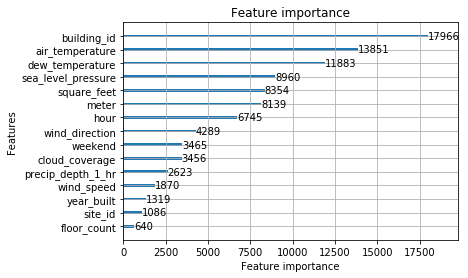

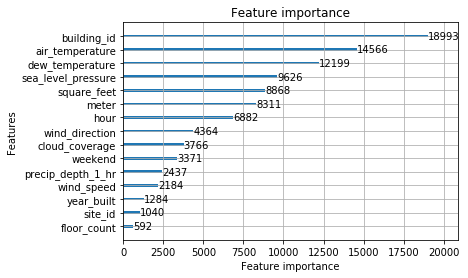

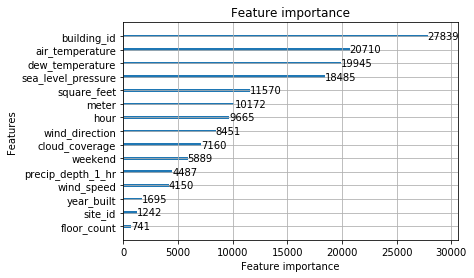

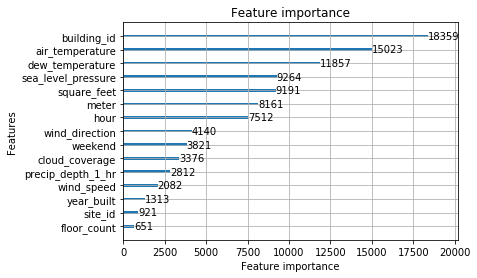

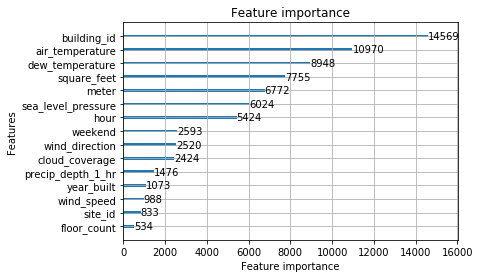

In [19]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [41]:
%%time
test_df=test[test["primary_use"]==0]
test_df.drop("primary_use",axis=1,inplace=True)
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()
results.tofile('c0.dat')

## Meter 1

In [41]:
train_df=train[train["primary_use"]==1]
train_df.drop("primary_use",axis=1,inplace=True)
train_df=train_df.reset_index().drop("index",axis=1)
train_df=train_df

target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)


#categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
#categorical_features = ["building_id", "site_id", "meter", "primary_use","floor_count","year_built","hour","weekend"]
categorical_features = ["building_id", "site_id", "meter","floor_count","year_built","hour","weekend"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.864396	valid_1's rmse: 1.04913
[50]	training's rmse: 0.668776	valid_1's rmse: 0.955671
[75]	training's rmse: 0.610328	valid_1's rmse: 0.955894
[100]	training's rmse: 0.571239	valid_1's rmse: 0.958308
Early stopping, best iteration is:
[60]	training's rmse: 0.637743	valid_1's rmse: 0.953278
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.862776	valid_1's rmse: 1.0027
[50]	training's rmse: 0.660752	valid_1's rmse: 0.925188
[75]	training's rmse: 0.599988	valid_1's rmse: 0.926751
[100]	training's rmse: 0.560103	valid_1's rmse: 0.929842
Early stopping, best iteration is:
[55]	training's rmse: 0.643228	valid_1's rmse: 0.92402
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.869982	valid_1's rmse: 1.03247
[50]	training's rmse: 0.664502	valid_1's rmse: 0.926617
[75]	training's rmse: 0.603989	valid_1's rmse: 0.919117
[100]	training's rmse:

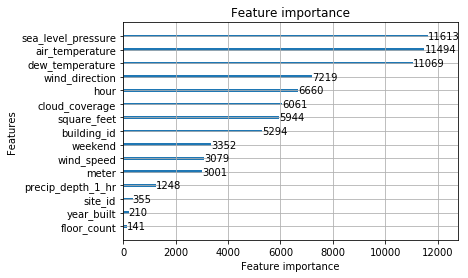

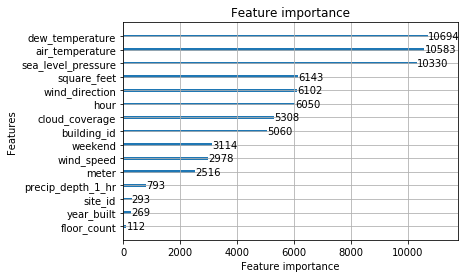

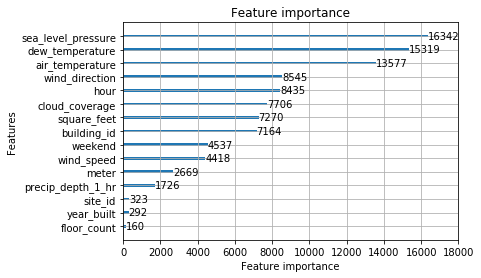

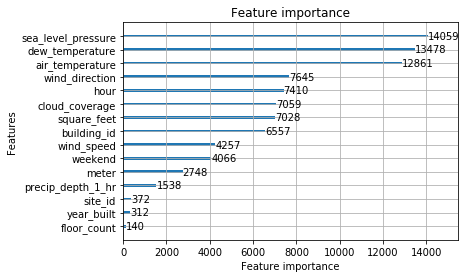

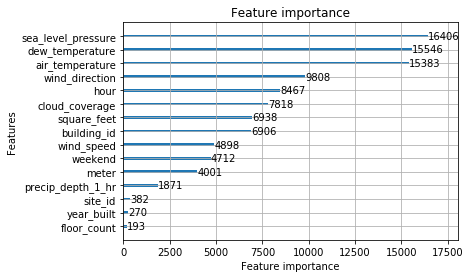

In [42]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [28]:
%%time
test_df=test[test["primary_use"]==1]
test_df.drop("primary_use",axis=1,inplace=True)
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()
results.tofile('c1.dat')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


CPU times: user 1h 24min 42s, sys: 2min 55s, total: 1h 27min 38s
Wall time: 1h 39min 24s


## Meter 2

In [45]:
train_df=train[train["primary_use"]==2]
train_df.drop("primary_use",axis=1,inplace=True)
train_df=train_df.reset_index().drop("index",axis=1)
train_df=train_df

target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)


#categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
#categorical_features = ["building_id", "site_id", "meter", "primary_use","floor_count","year_built","hour","weekend"]
categorical_features = ["building_id", "site_id", "meter","floor_count","year_built","hour","weekend"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.04306	valid_1's rmse: 1.18166
[50]	training's rmse: 0.831234	valid_1's rmse: 1.01337
[75]	training's rmse: 0.770749	valid_1's rmse: 0.993464
[100]	training's rmse: 0.727815	valid_1's rmse: 0.988982
[125]	training's rmse: 0.692902	valid_1's rmse: 0.988556
[150]	training's rmse: 0.67032	valid_1's rmse: 0.989557
Early stopping, best iteration is:
[114]	training's rmse: 0.70697	valid_1's rmse: 0.988214
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.04195	valid_1's rmse: 1.11758
[50]	training's rmse: 0.819053	valid_1's rmse: 0.977168
[75]	training's rmse: 0.755476	valid_1's rmse: 0.962564
[100]	training's rmse: 0.714048	valid_1's rmse: 0.963264
[125]	training's rmse: 0.681422	valid_1's rmse: 0.964761
Early stopping, best iteration is:
[81]	training's rmse: 0.744725	valid_1's rmse: 0.962162
Training until validation scores don't improve for 50 rounds
[25]	training's rmse

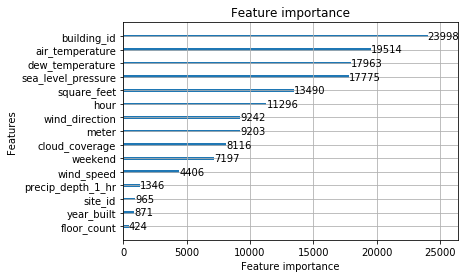

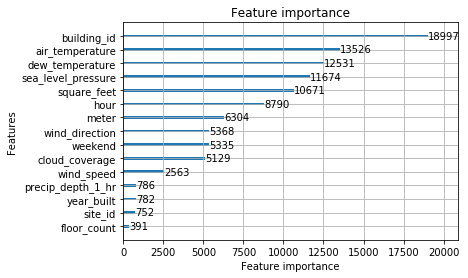

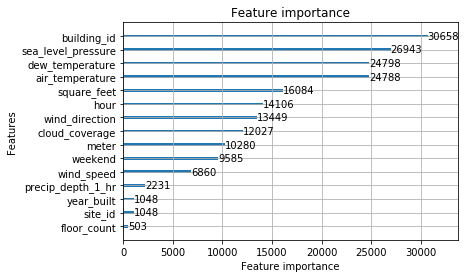

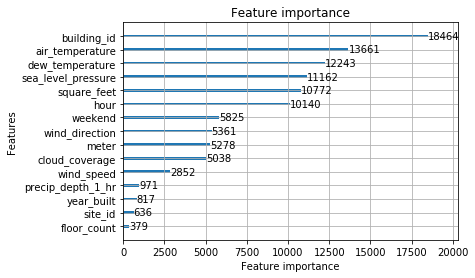

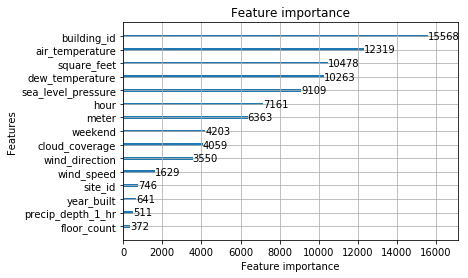

In [46]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [47]:
%%time
test_df=test[test["primary_use"]==2]
test_df.drop("primary_use",axis=1,inplace=True)
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()
results.tofile('c2.dat')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


CPU times: user 51min 8s, sys: 1min 2s, total: 52min 10s
Wall time: 38min 1s


## Meter 3

In [48]:
train_df=train[train["primary_use"]==3]
train_df.drop("primary_use",axis=1,inplace=True)
train_df=train_df.reset_index().drop("index",axis=1)
train_df=train_df

target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)


#categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
#categorical_features = ["building_id", "site_id", "meter", "primary_use","floor_count","year_built","hour","weekend"]
categorical_features = ["building_id", "site_id", "meter","floor_count","year_built","hour","weekend"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.01731	valid_1's rmse: 1.12216
[50]	training's rmse: 0.802811	valid_1's rmse: 0.998414
[75]	training's rmse: 0.737008	valid_1's rmse: 0.991853
[100]	training's rmse: 0.698372	valid_1's rmse: 0.991584
[125]	training's rmse: 0.670986	valid_1's rmse: 0.992623
Early stopping, best iteration is:
[79]	training's rmse: 0.729966	valid_1's rmse: 0.991404
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.02902	valid_1's rmse: 1.0504
[50]	training's rmse: 0.809389	valid_1's rmse: 0.909098
[75]	training's rmse: 0.74315	valid_1's rmse: 0.897691
[100]	training's rmse: 0.704197	valid_1's rmse: 0.898121
[125]	training's rmse: 0.674489	valid_1's rmse: 0.899484
Early stopping, best iteration is:
[87]	training's rmse: 0.722805	valid_1's rmse: 0.897376
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.00299	valid_1's rmse: 1.17228
[50]	training's rmse: 0

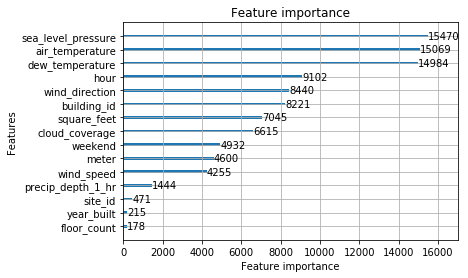

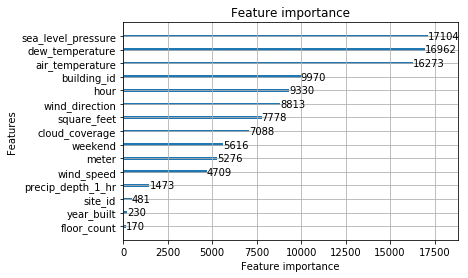

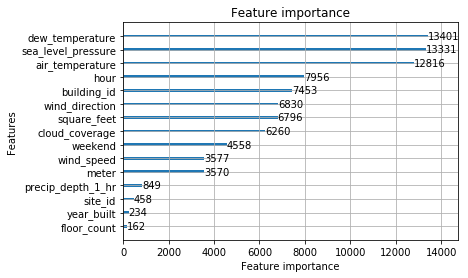

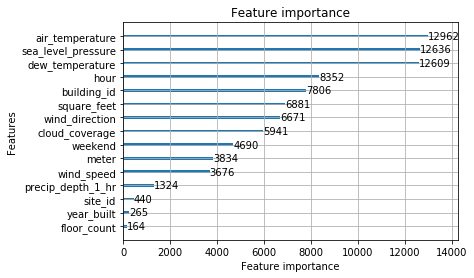

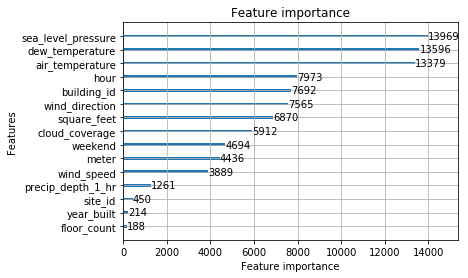

In [49]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [50]:
%%time
test_df=test[test["primary_use"]==3]
test_df.drop("primary_use",axis=1,inplace=True)
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()
results.tofile('c3.dat')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


CPU times: user 13min 2s, sys: 19 s, total: 13min 21s
Wall time: 8min 16s


## Submission

In [32]:
y_test0 = np.fromfile('c0.dat')
y_test1 = np.fromfile('c1.dat')
y_test2= np.fromfile('c2.dat')
y_test3 = np.fromfile('c3.dat')
sample_submission = pd.read_csv('sample_submission.csv')
test_df=pd.read_csv("test.csv")

sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = y_test0
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = y_test1
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = y_test2
sample_submission.loc[t

In [ ]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')